# Práctica 3.2: Clustering

<center><h3>
    Fernando Fraile Mulas
</h3></center>

## Instrucións

Isto é un **Jupyter Notebook**, un documento que integra código Python nun arquivo Markdown.
Isto permítenos, ir exexutando celdas de código pouco a pouco, así como xerar automáticamente un informe ben formateado da práctica.

Podes engadir unha celda co botón **"Insert"** da barra de ferramentas, e cambiar seu tipo con **"Cell > Cell Type"**

Para executar unha celda de código, seleccionarémola e pulsaremos a botón **"▶ Run"** da barra de ferramentas.
Para pasar o documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Segue este guión ata o final. Executa o código proporcionado paso a paso comprendendo o que estás a facer e reflexionando sobre os resultados. Haberá preguntas intercaladas ao longo do guión, responde a todas elas na sección reservada para ese fin: **"Respostas ao cuestionario"**. Por favor, non modifiques ningunha liña de código agás cando se che pida explícitamente.

Non esquezas insertar o teu **nome e apelidos** na celda superior.

## Entrega da práctica

A data límite de entrega será a indicada no Campus Virtual. A entrega consistirá nun único arquivo comprimido co nome `APELIDOS_NOME_Clustering.zip` que conteña os seguintes ficheiros:

 * `APELIDOS_NOME_Clustering.html`: Arquivo HTML froito da exportación do presente Notebook, coas preguntas respondidas ao final do documento.
 * `APELIDOS_NOME_Clustering.ipynb`: Arquivo Jupyter Notebook fonte.
 * Arquivo de datos do problema de libre elección.

## Números aleatorios

<span style="color:red">**MOI IMPORTANTE:**</span> Vamos a establecer un *seed* cun valor predefinido inmediatamente antes de executar calquera operación cun compoñente aleatorio. Así nos aseguraremos de que os nosos resultados sexan repetibles.

Isto é, imos poñer `np.random.seed(SEED_VALUE)` antes de:
 - `train_test_split()`
 - `fit()`
 - `predict()`
 
Tamén imos poñer `random_state=SEED_VALUE` en aquelas funcións que o admitan (coma o construtor de `KMeans`).

Haberá ocasión nas que isto sexa excesivo, pero así curámonos en despistes.

# Introdución

Nesta práctica imos reforzar os conceptos vistos nas clases teóricas sobre aprendizaxe non supervisada. Comezaremos traballando sobre un conxunto de datos xa coñecido, o da superficie e prezo das vivendas, sobre o cal aplicaremos o algoritmo **k-means**. O segundo exercicio consistirá en aplicar clustering a un problema de libre elección.

# Clustering sobre o dataset das vivendas

Na práctica anterior fomos capaces de dar un prezo estimado das vivendas a partir da súa superficie. Agora imos usar as dúas variables, superficie e prezo, para buscar novas relacións entre os nosos datos e facer unha distinción en varias categorías de vivendas.

Cargamos os datos empregando a función `read_csv()`:

In [1]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

vivendas = pd.read_csv('vivendas.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

Nesta práctica non vai ser preciso dividir os datos en dous conxuntos (adestramento e test), xa que o que queremos atopar son **novas** relacións. Isto implica tamén que non vai haber ningunha etapa de validación de modelos. En lugar diso, o que se adoita facer é unha etapa de análise e interpretación dos agrupamentos obtidos.

## Agrupamento empregando funcións propias

___K-means___ é un algoritmo de clasificación non supervisada (*clustering*) que agrupa os exemplos dun conxunto de datos en $k$ grupos baseándose nas súas características. O agrupamento realízase minimizando a suma de distancias (habitualmente distancia cadrática) entre cada exemplo e o centroide do grupo (*cluster*) ao que foi asignado. 

O algoritmo consta de 3 etapas diferenciadas:

1. **Inicialización**: unha vez escollido o número de grupos $k$, establécense aleatoriamente $k$ centroides no espazo de datos.
2. **Asignación dos exemplos aos centroides**: cada instancia do dataset é asignada ao seu centroide máis próximo.
3. **Actualización dos centroides**: para cada grupo, actualízase a posición do centroide tomando como novo centroide a posición media dos exemplos pertenecentes a dito grupo.
 
Os pasos 2 e 3 repítense durante $n$ iteracións. O algoritmo resolve un problema de optimización, sendo a función a optimizar (minimizar) a suma das distancias cadráticas de cada exemplo ao centroide do seu cluster.
 
Imos empregar as seguintes funcións:

In [2]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            diff = a[i] - b[j]
            matriz_distancias[i, j] = np.sqrt(diff[0] ** 2 + diff[1] ** 2)
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centroides(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        x_cluster_i = x[clusters==i]
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]
    
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        dist_centroides = calcula_distancias(x, centroides)
        clusters = np.argmin(dist_centroides, axis=1)
        centroides = actualiza_centroides(x, clusters, centroides)
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

Xa podemos realizar un primeiro agrupamento. Convertemos o dataset a unha matriz porque neste caso facilítanos as operacións:

In [3]:
vivendas_mat = vivendas.values

Tomamos 3 exemplos ao azar como centroides iniciais (non debemos esquecernos de definir unha semente para que os resultados sexan reptibles):

In [4]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centroides_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centroides_iniciais

array([[210.  , 299.9 ],
       [106.  , 104.96],
       [ 76.  ,  80.15]])

Invocamos o método `k_medias`:

In [5]:
# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(vivendas_mat, centroides_iniciais, n_iter)

A variable `agrupamento_1` almacena o historial de custos, os centroides e as asignacións de cada exemplo aos 3 clusters en todas as iteracións. Aquí tes algúns exemplos da información á que podes acceder:

In [6]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]


3649.4144836282358

In [7]:
# Custo final
agrupamento_1['custo'][n_iter-1]

2072.6093651192277

In [8]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[208.57142857, 351.38357143],
       [126.61538462, 157.60307692],
       [ 93.87878788,  86.56242424]])

In [9]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 1, 1, 2, 1, 2])

Imos graficar paso a paso como foi converxendo o algoritmo para chegar ao agrupamento definitivo:

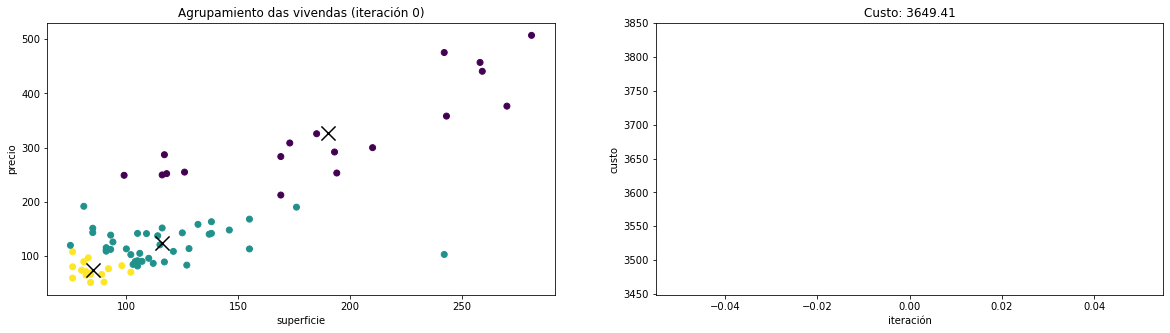

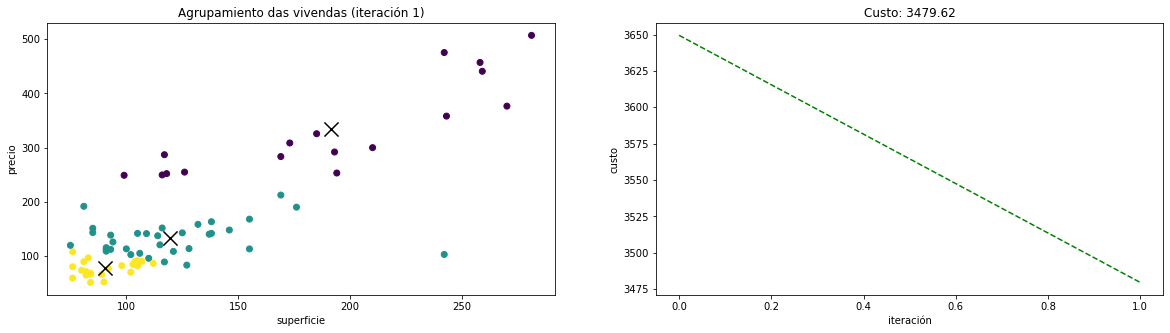

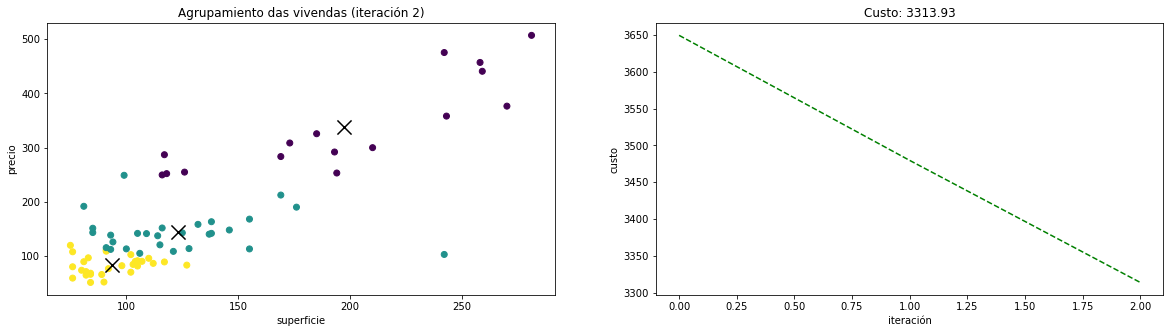

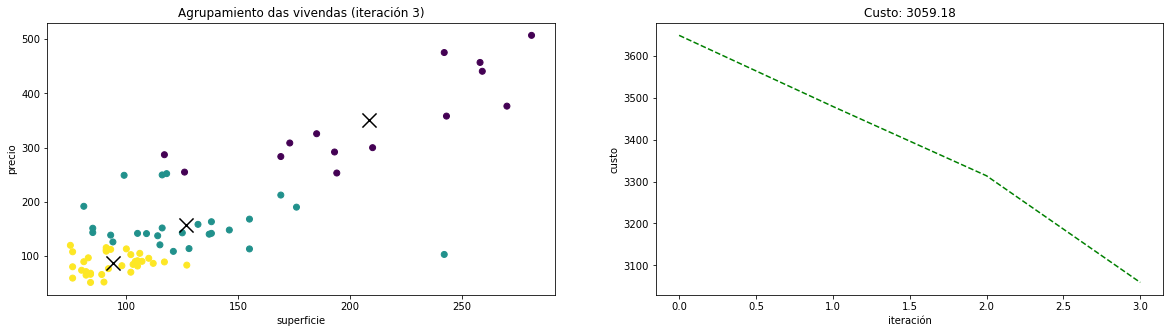

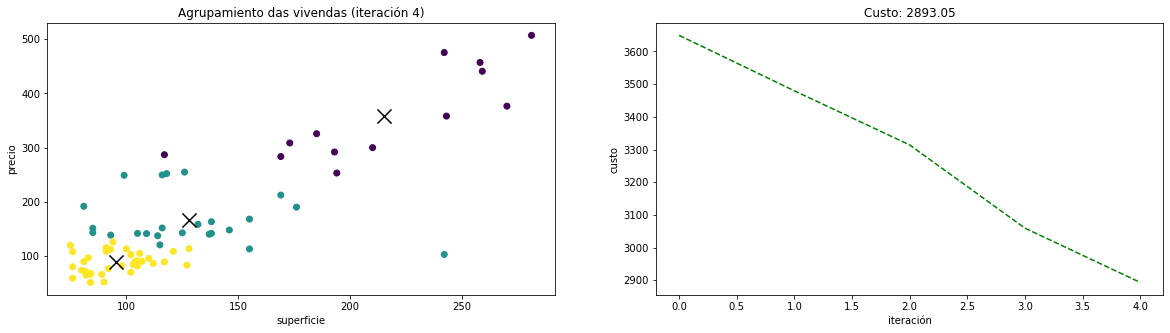

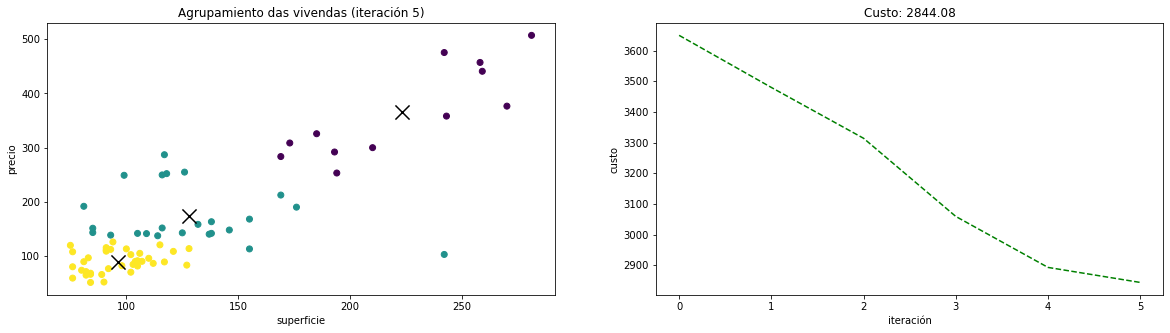

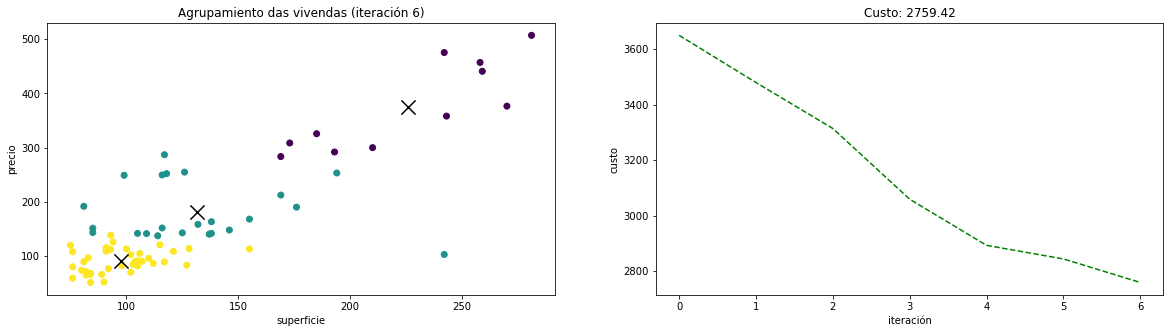

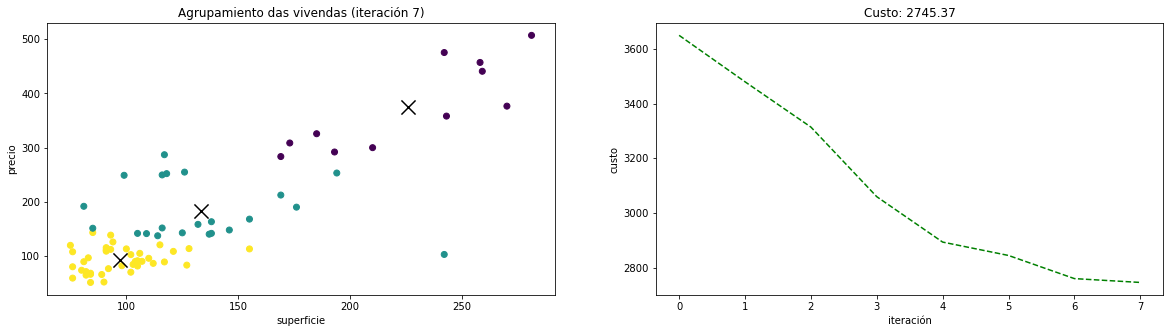

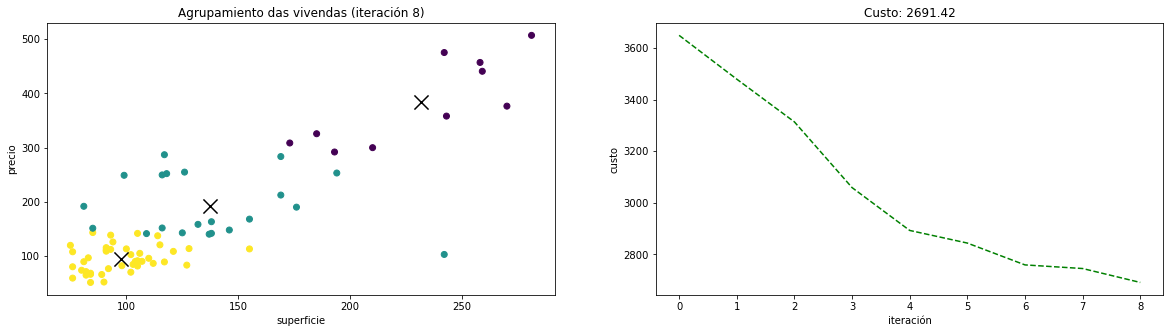

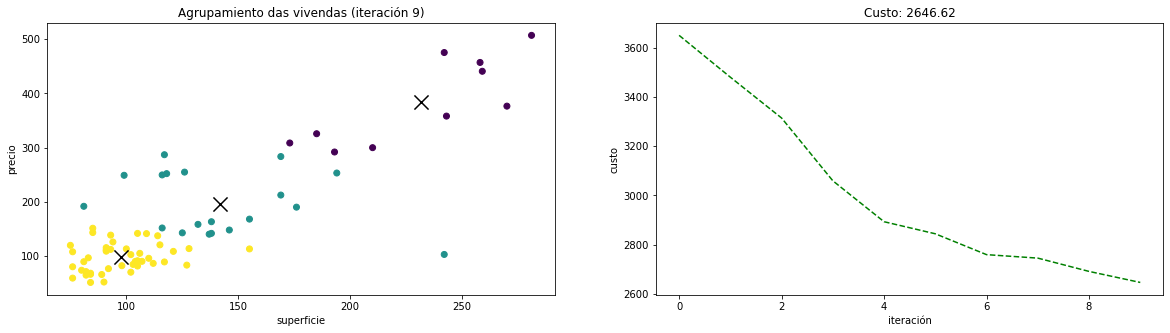

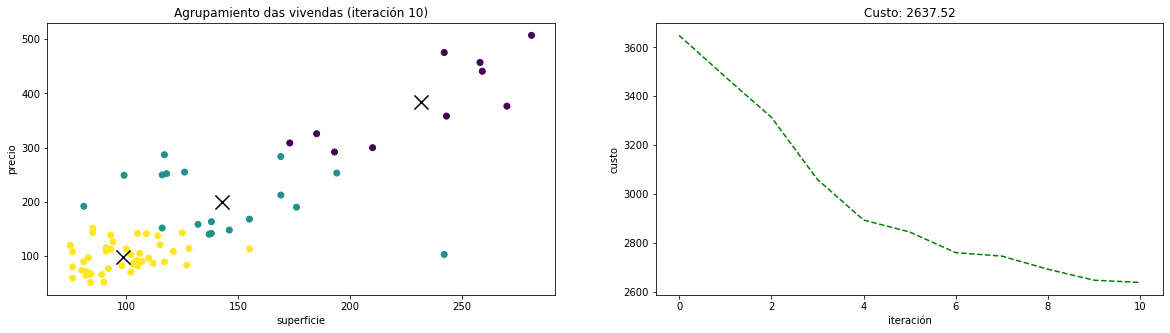

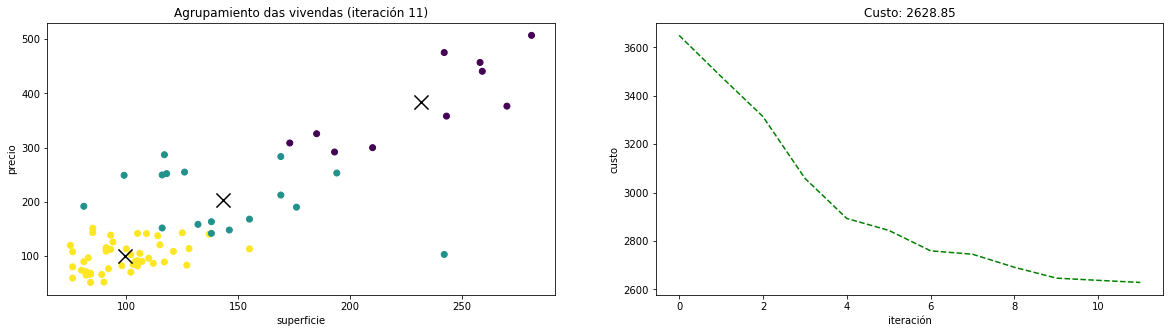

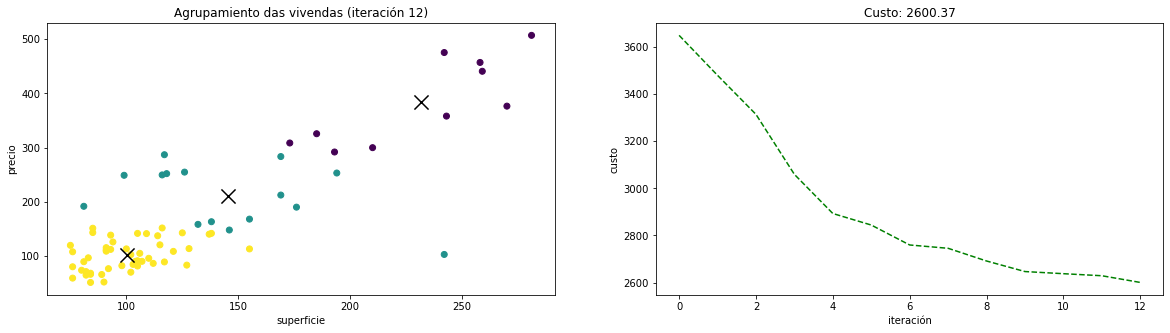

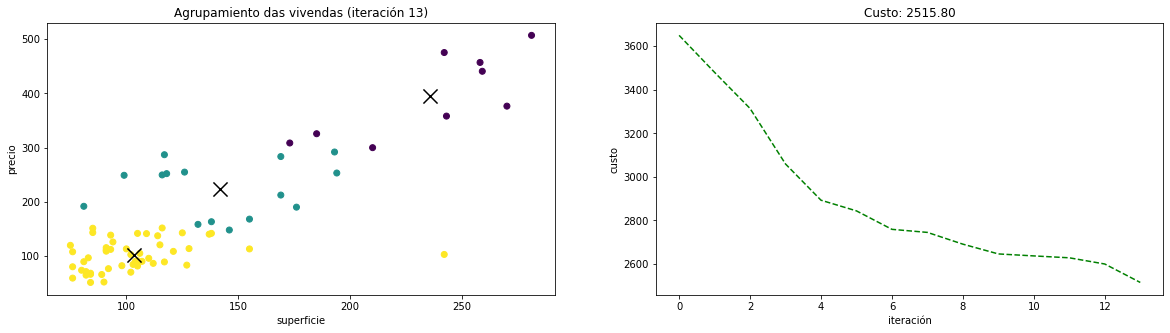

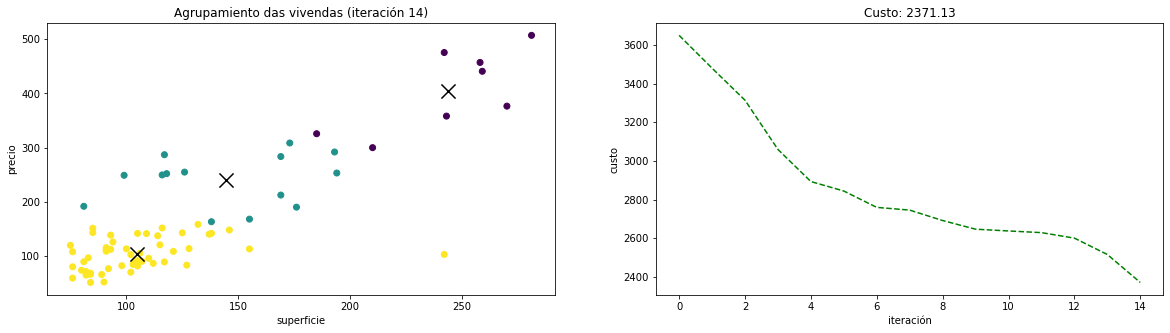

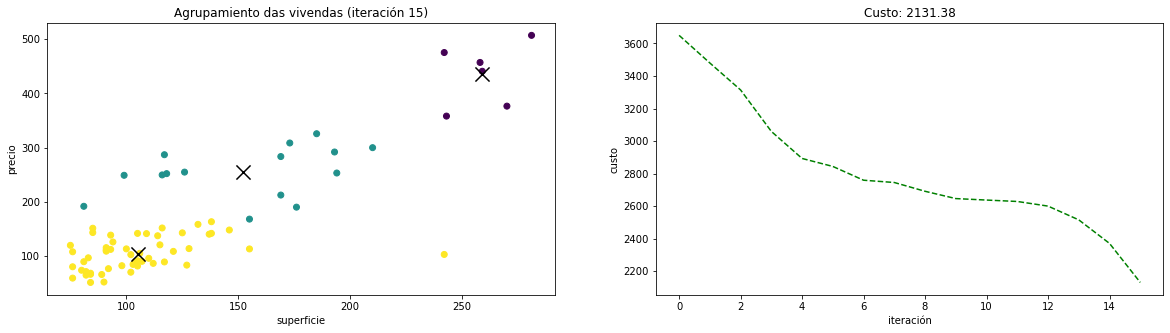

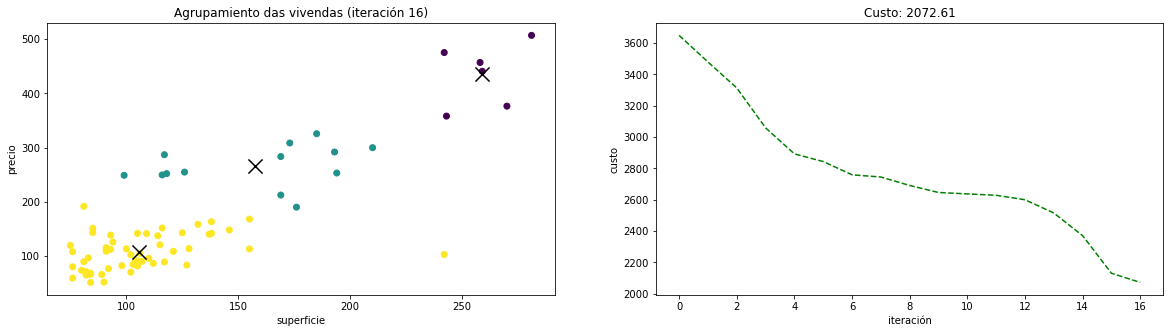

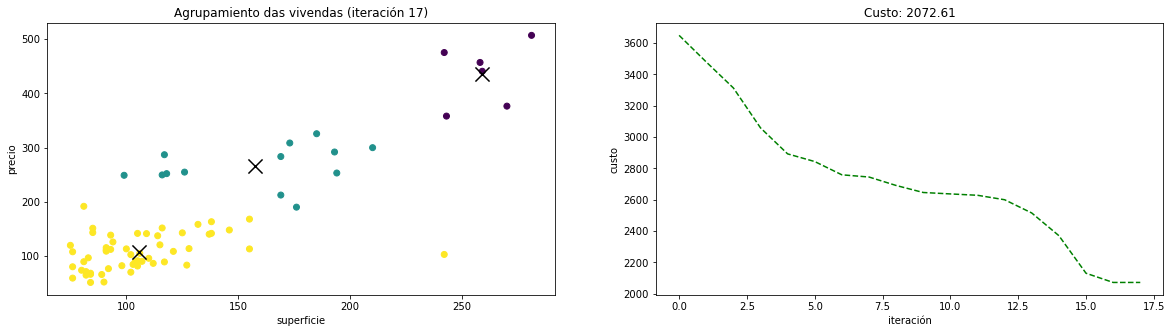

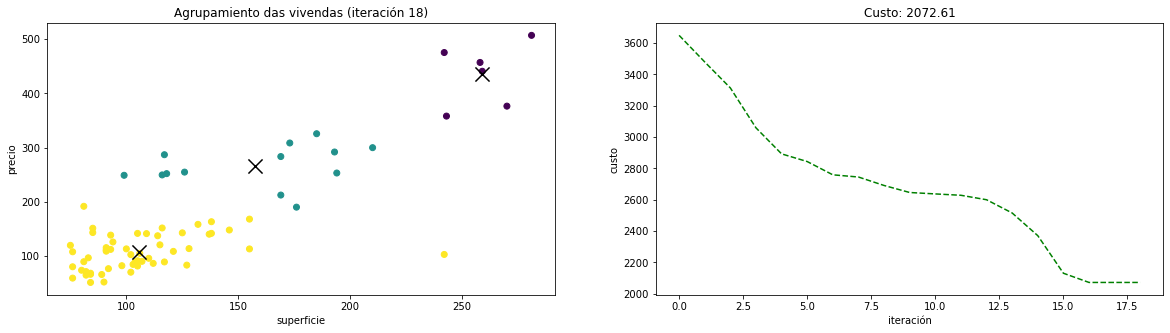

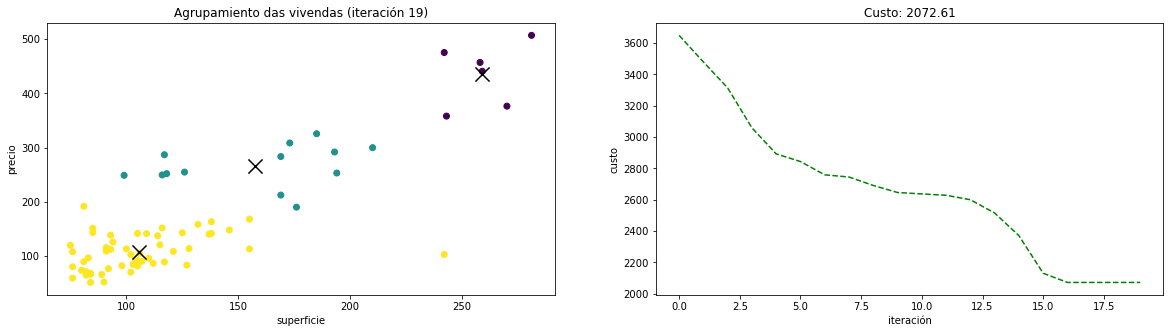

In [10]:
import matplotlib.pyplot as plt

for i in range(n_iter):
    fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])
    ax2 = fig.add_subplot(122, projection='rectilinear')
    
    # Engadimos os scatterplots
    ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=agrupamento_1['clusters'][i])  #Vivendas
    ax1.scatter(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],
                s=200, marker='x', color='black')  # Centroides
    ax1.set_title("Agrupamiento das vivendas (iteración {})".format(i))  # Poñemos un título
    ax1.set_xlabel("superficie")  # Nombramos os eixos
    ax1.set_ylabel("precio")
    
    # Engadimos os custos
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")


    plt.show()  # Mostramos a figura por pantalla

Nas figuras anteriores, a gráfica da esquerda indica sempre o agrupamento realizado. Os exemplos do conxunto de datos coloréanse de distinta cor en función do cluster ao que son asignados. As **x** cunha circunferencia arredor ubican os centroides. Na gráfica da dereita temos a evolución do custo ($J$) nas sucesivas iteracións, tal e como faciamos en regresión lineal.

Agora que viches o proceso de clustering paso a paso, trata de responder ás seguintes cuestións.

> ❓ **_Pregunta 1._**  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?

> ❓ **_Pregunta 2._**  Explica que é a saída da función `calcula_distancias`.

> ❓ **_Pregunta 3._**  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centr`.

> ❓ **_Pregunta 4._**  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).

### Inicialización aleatoria múltiple dos centroides

Se cambiamos os centroides iniciais, o algoritmo pode non converxer aos mesmos resultados.

In [12]:
SEED_VALUE = 22634  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centroides_iniciais_2 = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centroides_iniciais_2

array([[259.  , 440.83],
       [ 81.  ,  89.52],
       [126.  , 254.81]])

In [13]:
# Realizamos un novo agrupamento
agrupamento_2 = k_medias(vivendas_mat, centroides_iniciais_2, n_iter)

Neste caso, posto que o problema é pequeno e sinxelo, 20 iteracións son máis que suficientes para converxer ao agrupamento óptimo, sexan cales sexan os centroides de arranque:

In [14]:
# Centroides finais do primeiro agrupamento
agrupamento_1['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [15]:
# Centroides finais do segundo agrupamento
agrupamento_2['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [105.77777778, 107.42740741],
       [157.30769231, 265.95846154]])

Fíxate que, aínda que en esencia os resultados son os mesmos que no primeiro agrupamento, os centroides 2 e 3 están intercambiados, polo que tecnicamente a solución á que chega o algoritmo é outra (e, porén, todo o proceso iterativo foi distinto).

En moitos problemas reais os resultados cambiarán moito en función de como inicialicemos os centroides. Incluso no problema das vivendas, se o número de iteracións é máis pequeno (por exemplo, 10), non sempre se acadará o óptimo global. Porén sóense realizar múltiples ($m$) inicializacións aleatorias dos centroides. A seguinte función é unha extensión da función base `k_medias` que permite executar o k-means para $m$ inicializacións distintas dos centroides e un valor $k$ constante:

In [16]:
# Función k-means de inicialización aleatoria múltiple
def k_medias_inicializacion_multiple(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

Imos probar a función anterior:

In [17]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 3
agrupamento_3 = k_medias_inicializacion_multiple(x=vivendas, n=n_iter, m=m_ini, k=k_cent)

In [18]:
# Mellor iteración
agrupamento_3['mellor_iteracion']

5

In [19]:
# Mellores centroides
agrupamento_3['mellores_centroides']

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [20]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset:
agrupamento_3['mellor_asignacion'][:6]

array([2, 1, 1, 2, 1, 2])

> ❓ **_Pregunta 5._**  Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?

### Selección do número de centroides

Polo de agora mantivemos o valor de $k$ constante, facendo sempre agrupamentos en 3 clusters. Unha pregunta que che podería xurdir a estas alturas é como saber cal é o número de centroides máis axeitado. A selección do $k$ óptimo é a miúdo ambigua, con interpretacións que dependen da forma e a escala da distribución de puntos no conxunto de datos. Aumentar o $k$ sen penalización sempre reducirá o valor do custo na agrupación resultante, ata o caso extremo de custo cero se cada punto dos datos se considera como o seu propio agrupamento (é decir, cando $k$ é igual ao número de exemplos do conxunto de datos). Intuitivamente, a elección óptima de $k$ acadará un equilibrio entre a compresión máxima dos datos utilizando un só cluster e a máxima precisión ao asignar cada instancia ao seu cluster propio. 

Cando o valor apropiado de $k$ non é evidente a partir do coñecemento previo das propiedades do conxunto de datos, existen métodos que nos axudan a tomar esta decisión. Un dos máis sinxelos é o **método do cóbado** (en inglés, *elbow method*), o cal analiza a redución do custo en función do número de clusters: debe elixirse aquel número de clusters tal que, ao agregar outro cluster máis non se acaden resultados moito mellores. Dun xeito máis formal, se se grafica o custo obtido en función de $k$, os primeiros agrupamentos terán un alto erro por agrupar moitos datos en poucos clusters, pero nalgún momento a ganancia marxinal caerá, provocando un "cóbado" no gráfico. O número de clusters fíxase a este punto, de ahí o nome do método. 

O seguinte script executa o método `k_medias_multi_ini` para distintos valores de $k$ (o mínimo é $k=2$):

In [21]:
SEED_VALUE = 42  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    agrupamento = k_medias_inicializacion_multiple(x=vivendas, n=n_iter, m=m_ini, k=k)
    custos_finais.append(agrupamento['custo_minimo'])
    centroides_finais.append(agrupamento['mellores_centroides'])
    clusters_finais.append(agrupamento['mellor_asignacion'])

> ❓ **_Pregunta 6._**  Cantas veces se executa o algoritmo k-means no script anterior?

Agora imos aplicar o método do cóbado para determinar o número óptimo de clusters. Para iso, graficamos a evolución do custo en función de $k$:

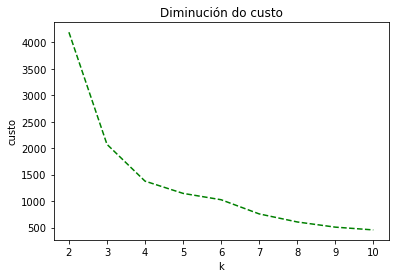

In [22]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=4$. A partir deste valor a mellora que obtemos é moito menos significativa. Por tanto podemos asumir que o número de clusters ideal é 4:

In [23]:
k_mellor = 4

# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
centroides_mellor

array([[128.75      , 145.0095    ],
       [ 94.65714286,  88.31571429],
       [155.75      , 272.275     ],
       [258.83333333, 435.845     ]])

In [24]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset
clusters_mellor = clusters_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor[:6]

array([0, 2, 2, 0, 2, 1])

Graficamos o último agrupamento, que imos considerar o definitivo:

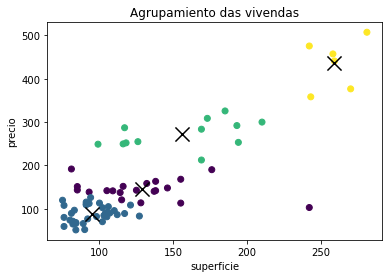

In [25]:
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=clusters_mellor)  #Vivendas
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', color='black')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("superficie")  # Nombramos os eixos
ax1.set_ylabel("precio")

plt.show()  # Mostramos a figura por pantalla

### Interpretación dos resultados

Quedaría agora unha última etapa de análise e interpretación dos resultados. Haberá situacións (coma esta) onde a interpretación sexa bastante trivial. Sen embargo, en moitos problemas reais onde se traballa cun maior número de variables (porén, xa non estamos falando de interpretar un simple gráfico 2D) pode resultar moi complexo lograr atribuírlle un significado aos grupos formados.

> ❓ **_Pregunta 7._**  Fai unha breve interpretación dos clusters obtidos.

## Agrupamento coa función `KMeans`

Unha vez máis, `scikit-learn` facilítanos as tarefas de clustering proporcionándonos paquetes e funcións moi útiles. Unha das funcións imprescindibles é `KMeans`. No seguinte script imos volver a obter o primeiro dos agrupamentos que realizamos no exercicio anterior, pero invocando a `KMeans` en lugar de `k_medias`:

In [71]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter = 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(vivendas)

O argumento `algorithm="full"` simplemente nos asegura que por debaixo estamos empregando o mesmo método que o que implementamos no exercicio anterior (hai varias implementacións, podes consultalas na axuda de `scikit-learn`). Vemos que os centroides que obtemos con `KMeans` son os mesmos que obtiñamos antes coa nosa implementación propia:

In [72]:
# Centroides da implementación propia
agrupamento_1['centroides'][-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [73]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

Bótalle un ollo aos atributos que contén a clase `KMeans`. Observa que entre todos os datos de saída non se inclúe directamente o custo da función $J$ coa que estivemos traballando. Inclúese a suma de todas as distancias, sen facer a media:

In [74]:
# Custo final coa implementación propia
agrupamento_1['custo'][-1]

2072.6093651192277

In [75]:
# Custo final coa función KMeans
agrupamento_4.inertia_ / len(vivendas)

2072.6093651192286

Tamén podemos facer o cálculo manualmente, usando a función $J$ que temos definida:

In [76]:
j(x=vivendas_mat, centroides=agrupamento_4.cluster_centers_, clusters=agrupamento_4.labels_)

2072.6093651192286

**************************************************************

# Respostas ao cuestionario (4 puntos)

**LEMBRA:** Non esquezas de escribir teu nome e apelidos na segunda celda do presente documento.

**Pregunta 1**

El coste viene dado por la función j, la cual se pretende optimizar, para obtener el coste mínimo. Primero se 
obtiene las distnacias de cada punto con su cluster, guardándolas en la variable distnacias. Luego realiza la suma 
de las distancias euclidianas al cuadradok, y luego se divide entre el número de datos para normalizar. Ese valor 
es el coste de la función, y se va reduciendo hasta llegar al mínimo

**Pregunta 2**
La función calcula distnacias tiene como argumetnos los valores del dataset en forma matricial, y los centroides
que de la iteracción del bucle acutal. Primero genera una matriz no inicializada poniendo el número de filas como las filas
del dataset, y el número de columnas el número de filas de los centroides, es decir 3. Luego calcula la distancia de 
cada punto de x, con cada punto de los centroides, colocando la distnacia del primer punto de x con el primer centroide 
en la primera fila y primera columna, y así sucesivamente. De este modo, se obtiene la distancias de todos los puntos con los 3 centroides. La distnacia se calcula mediante la distnacia euclidiana. 


**Pregunta 3**

La variable clusters tiene almacenados a qué cluster pertenece cada punto, teniendo en cuenta las distancias calculadas previamente, asignando a cada punto el cluster que tenga una distancia menor calculada. Los clusters en este caso podrán serel 0, 1 o 2. Por lo que, la variable x_cluster_i almacena los datos que están asignados a cada cluster (0,1 o 2 ya que el centroides.shape[0] tiene valor de 3, por ser el número de centroides). Ahora actualiza los centroides de cada cluster con np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]. Realiza la suma de los puntos que están en cada cluster, para posteriormente realizar la división entre el número de puntos que hay en el cluster, para actualizar el valor del centroide. 

**Pregunta 4**
La inicialización se realiza en: 

SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centroides_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centroides_iniciais

Se selecciona una semilla aleatoria, y se eligen 3 centroides aleatoriamente, cogiendo 3 puntos de los datos. 

La asignación de las instanciadas a su centroide más próximo se realiza ya en el algoritmo k_medias, con la función np.argmin(dist_centroides, axis=1), que asigna la el centroide con distancia mínima para cada punto, calculadas con la función calcula_distnacias. 

La actualización de los clusters se realiza con actualiza_centroides, explicada en las preguntas anteriores. 

En las líneas posteriores de k_medias, se guarda el estado del algoritmo en cada iteracción, para obtener las etadísticas y graficarlas posteriormente, para analizar su evolución y convergencia de la función J. 


**Pregunta 5**
Devuelve los datos de la mejor convergencia del algoritmo, entre todas las inicializaciones de este. Se entiende por mejor convergencia a la que tenga el coste más bajo, ya que se escoge la itección con el coste final más bajo. Los datos que se 
devuelven son el coste mencionado, el índice de la iteracción elegida como mejor, los centroides finales de dicha iteracción y los clusters finales para cada dato de las vivendas de la mejor iteracción. 


**Pregunta 6**

k_medias_inicializacion_multiple se ejecuta k_max+1-2=kmax-1 veces, es decir, 9 veces. Por otro lado, dentro de la función k_medias_inicializacion_multiple se ejecuta k_medias 10 veces, por lo que k_medias se ejecuta un total de 90 veces. 

**Pregunta 7**
Se pueden sacar las siguientes conclusiones analizando la gráfica. 

La opción óptima es dividir el dataset en 4 cluster, agrupando las vivivienda en precio bajo, precio medio, precio alto y viviendas de lujo. Además, se puede observar como la cantidad de viviendas en cada categoría disminuye conforme su precio y superficie son más altos. 

Por otro lado, se observa como la variables precio pesa más que la variable superficie a la hora de asignar el dato a un cluster, ya que vemos variaciones de agrupación en variables con un superficie muy próximo, pero con una precio más distant. Por lo que el precio va a ser mucho más relevante a la hora de clasificar a las viviendas. 


**************************************************************

# Modelado dun problema de libre elección 

## Enunciado

Pon en práctica os teus coñecementos de aprendizaxe non supervisado e intenta agora ti buscar relacións entre os datos dun problema que se che ocorra. Nos exercicios anteriores abordouse o caso de 2 variables, polo que animámoste agora a que trates de aplicar clustering sobre un problema con máis dimensións. O único requerimento obrigatorio é **empregar máis de dúas variables para o clustering**. Ten en conta que a nosa implementación de k-means (`k_medias`) está pensada para funcionar sobre conxuntos de datos con dúas variables, pero non é escalable a máis dimensións (certo é que as modificacións necesarias para logralo son mínimas). A vantaxe da función `KMeans` propia de `scikit-learn` é a súa flexibilidade, pois o seu parámetro `x` pode tomar como entrada conxuntos de datos cun maior número de variables. Ten tamén presente que ao aplicar clustering sobre un conxunto de datos de máis de 2 ou 3 variables, a súa visualización complícase e o mellor é visualizar o agrupamento por pares de variables de cara a obter unha boa interpretación.

Imos traballar co dataset Heart Disease patients (https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients), no que se fai referencias a distintas probas realizadas a pacientes con problemas cardíacos. Carga o ficheiro heart_disease_patients.csv e pon en práctica os teus coñecementos de agrupamento. Fai un breve estudo dos teus datos, incluíndo gráficas e comentarios propios. Realiza unha etapa de preprocesado, se o consideras necesario. Obtén un bo agrupamento dos pacientes, e da unha interpretación do mesmo. Lembra que non tés por que utilizar todas as variables incluídas no conxunto de datos. Ademais, podes probar a realizar distintos agrupamentos en subconxuntos do dataset inicial (por exemplo, agrupar por separado os homes e as mulleres).

Na avaliación do exercicio terase en conta a complexidade da solución (análise, preprocesado e creación do modelo de agrupamento), así como a claridade nas explicacións e a boa estruturación do traballo realizado. Proporciona todo o código que consideres necesario empregando scripts como os do exercicio anterior.

**************************************************************

## Resposta (6 puntos)

In [26]:
# INTRODUCE O TEU CÓDIGO AQUÍ (tamén podes usar celdas Markdown para as explicacións)

import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)
import numpy as np

pacientes= pd.read_csv('heart_disease_patients.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)
#Mostramos información sobre el dataset

print('Filas: {}'.format(pacientes.shape[0]))
print('Columnas: {}'.format(pacientes.shape[1]))
pacientes.info()

#Primero se separa del dataset en hombres y mujeres 
#No se aporta nada acerca de si el 0 es hommbre o mujer, por lo que se supone 0-mujer 1-hombre

mujeres = pacientes[pacientes['sex'] == 0]
hombres = pacientes[pacientes['sex'] == 1]





Filas: 303
Columnas: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 28.5 KB


Se va a realizar un estudio acerca de la influencia del colesterol, el tipo de dolor en el pecho y la edad y la presión sanguínea en reposo, para tratar de diagnosticar enfermedades cardíacas a los pacientes y clasificarlos en diversos grupo, según los valores
que preseten en estos datos mencionados. El fin principial es facilitar el diagnístico de los médicos, clasificando a próximos pacientes en un grupo de los creados, y así poder aplicar el mismo tratamiento o medicación.  Para ello se buscará agruparlos, de forma que se creen grupos y se puedan clasificar en una enfermedad u otra. Se separará el dataset en hombres y mujeres, por la diferencia biológica existente, para tratar que el agrupamiento sea lo más preciso posible, ya que ayudará a los médicos a diagnosticar a los pacientes próximos. 
Se mostrarán los datos para mujeres. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 4 to 301
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       97 non-null     int64
 1   chol      97 non-null     int64
 2   trestbps  97 non-null     int64
 3   cp        97 non-null     int64
dtypes: int64(4)
memory usage: 3.8 KB


<AxesSubplot:xlabel='trestbps', ylabel='cp'>

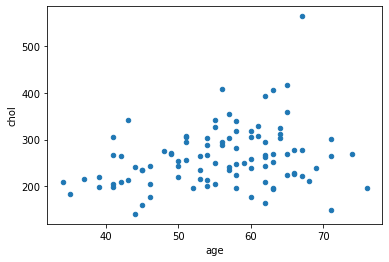

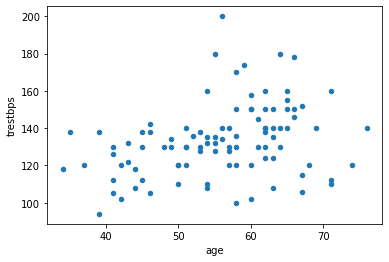

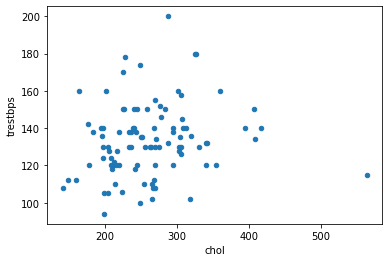

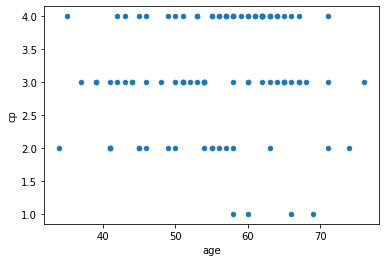

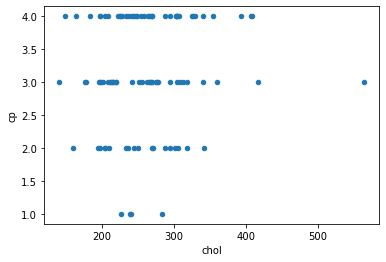

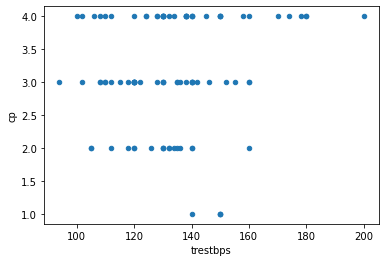

In [4]:
#Se muestran gráficas agrupando las variables de 2 en 2 para obtener un pequeño análisis inicial. 

mujeres_estudio = mujeres[['age','chol','trestbps', 'cp']]
mujeres_estudio.info()

mujeres_estudio.plot(kind='scatter', x='age', y='chol')
mujeres_estudio.plot(kind='scatter', x='age', y='trestbps')
mujeres_estudio.plot(kind='scatter', x='chol', y='trestbps')
mujeres_estudio.plot(kind='scatter', x='age', y='cp')
mujeres_estudio.plot(kind='scatter', x='chol', y='cp')
mujeres_estudio.plot(kind='scatter', x='trestbps', y='cp')





Como se puede observar, tanto en la edad con el colesterol, como en la edad con la presión sanguínea y el colesterol con la presión sanguínea, parece que va a seguir una distribucución lineal que se pueda aproximar mediante regresión, exceptuando algunos valores atípicos que se observan tras una primera visualización. 

En cuanto al dolor de pecho vemos que el más complicado sacar una primera conclusión, ya que solo tenemos 4 valores posibles para el dolor de pecho, lo que dificultad la visualización de una dependencia entre ambas variables. 

In [5]:
mujeres_mat = mujeres_estudio.values
#Recordar que las columnas son Edad, Colesterol, Presión Sanguínea y Tipo de dolor de pecho (en ese orden)
print(mujeres_mat)

[[ 41 204 130   2]
 [ 62 268 140   4]
 [ 57 354 120   4]
 [ 56 294 140   2]
 [ 48 275 130   3]
 [ 58 283 150   1]
 [ 50 219 120   3]
 [ 58 340 120   3]
 [ 66 226 150   1]
 [ 69 239 140   1]
 [ 65 225 150   4]
 [ 71 302 160   2]
 [ 61 330 130   4]
 [ 65 417 140   3]
 [ 41 198 105   2]
 [ 51 305 130   4]
 [ 46 177 142   3]
 [ 54 304 135   3]
 [ 65 269 155   3]
 [ 65 360 160   3]
 [ 51 308 140   3]
 [ 53 264 130   4]
 [ 53 216 128   3]
 [ 53 234 138   4]
 [ 51 256 130   3]
 [ 62 164 160   4]
 [ 44 141 108   3]
 [ 63 252 135   3]
 [ 60 258 150   4]
 [ 57 303 128   4]
 [ 71 265 110   3]
 [ 61 307 145   4]
 [ 43 341 132   4]
 [ 62 263 130   3]
 [ 35 183 138   4]
 [ 63 407 150   4]
 [ 45 234 130   2]
 [ 56 288 200   4]
 [ 62 209 124   4]
 [ 43 213 122   3]
 [ 55 250 135   2]
 [ 60 318 102   3]
 [ 42 265 102   4]
 [ 67 564 115   3]
 [ 54 214 110   3]
 [ 58 248 100   4]
 [ 54 288 132   2]
 [ 45 160 112   2]
 [ 59 249 174   4]
 [ 62 394 140   4]
 [ 56 409 134   4]
 [ 60 305 158   4]
 [ 63 195 14

Primero, se va a indicar la división en 4 grupos distintos (para buscar una simetría con los 4 tipos distintos de dolor de pecho), utilizando el algoritmo KmEans de scikit-learn, y se observará cuales los los 3 clusters, tras 20 iteracciones, indicando el coste final. 

In [6]:


from sklearn.cluster import KMeans


# Definimos o número de iteracións
n_iter = 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = mujeres_mat[np.random.choice(mujeres_mat.shape[0], size=4, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento = model.fit(mujeres_estudio)
np.random.seed(SEED_VALUE)
agrupamento = model.fit(mujeres_estudio)


# Centroides obtidos coa función KMeans
agrupamento.cluster_centers_







array([[ 51.72413793, 196.68965517, 124.48275862,   3.06896552],
       [ 57.19230769, 313.61538462, 140.92307692,   3.15384615],
       [ 56.89189189, 252.45945946, 134.62162162,   3.13513514],
       [ 62.6       , 438.2       , 135.8       ,   3.6       ]])

In [7]:
# Obtener las asignaciones de clúster para cada muestra
clusters_asignados = agrupamento.labels_

# Custo final coa función KMeans
agrupamento.inertia_ / len(mujeres_estudio)

955.4464980307498

Como se puede observar, el coste final es de 786, bastante bajo, por lo que el agrupamiento para bastante eficiente. Para analizar gráficamente los resultados obtenidos. Se va a graficar de 2 en 2 variables, para poder visualizarlo en una gráfica de 2 dimensiones. 

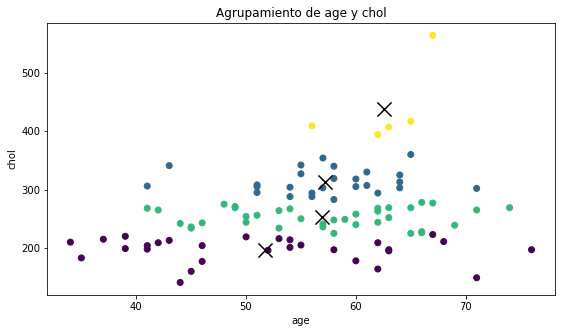

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento.cluster_centers_[:, :2]
ax1.scatter(mujeres_estudio['age'], mujeres_estudio['chol'], c=agrupamento.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de age y chol")  # Poñemos un título
ax1.set_xlabel("age")  # Nombramos os eixos
ax1.set_ylabel("chol")


plt.show()  # Mostramos a figura por pantalla

Como se puede observar, el dataset está claramente dividido en 4 clusters distintos, y se puede deducir que la variable colesterol pesa más a la hora de elegir el cluster al que pertenece una variable. Los centroides están situados muy próximos en la variable edad, mientras que es en el colesterol en el que se ven más diferencias. 


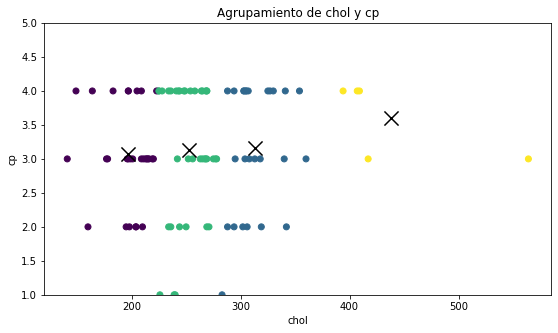

In [9]:

fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento.cluster_centers_[:, [1, 3]]
ax1.scatter(mujeres_estudio['chol'], mujeres_estudio['cp'], c=agrupamento.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("cp")

ax1.set_ylim(1, 5)



plt.show()  # Mostramos a figura por pantalla

En este caso se observa como la variable colesterol tiene mucho más peso que la varaible tipo de dolor de pecho,
a la hora de determinar los clusters. La variación de los centroides varía con respecto a la variación del colesterol, mientras que vemos que no varían con respecto al tipo de dolor de pecho (de hecho, en los cuatro tipos de dolor hay datos que pertenecen a los 4 clusters). 


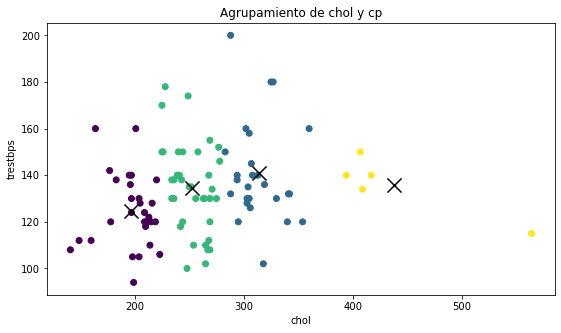

In [10]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento.cluster_centers_[:, [1, 2]]
ax1.scatter(mujeres_estudio['chol'], mujeres_estudio['trestbps'], c=agrupamento.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("trestbps")




plt.show()  # Mostramos a figura por pantalla

De nuevo se observa como la variable colesterol es la que más pesa a la hora de elegir el clusters, por lo que 
se puede concluír que la variable que más peso tiene es el colesterol. 


A continuación se realizará una evaluación de cual es el número de centroides óptimo, utilizando el método del codo. Para ello se verá la mejora en el coste con respecto a la ampliación del número de centroides, y cuando la variación sea lo suficientemente pequeña, se elegirá el valor de centroides como el óptimo.

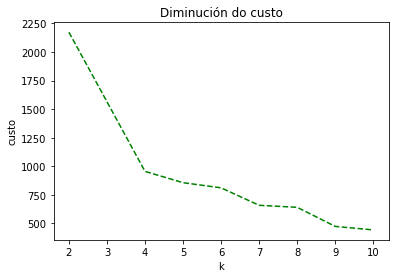

In [11]:

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    centr_iniciais = mujeres_mat[np.random.choice(mujeres_mat.shape[0], size=k, replace=False)]

    model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)
    
    # Axustamos o modelo aos datos
    np.random.seed(SEED_VALUE)
    agrupamento = model.fit(mujeres_estudio)
    custo_final = agrupamento.inertia_ / len(mujeres_estudio)

    custos_finais.append(custo_final)
    centroides_finais.append(agrupamento.cluster_centers_)
    clusters_finais.append( agrupamento.labels_ )
    
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()
    

Como se puede observar, el coste disminuye de forma considerable hasta k=5, luego se produce una disminución de la pendiente, y vuelve a descender de forma considerable hasta k=7, por lo se considera que el codo de la función está en este valor. 
Podemos decir entonces que la separación óptima en el caso de las mujeres es de 7 grupos en los que se clasificarían con el fin de clasificar el tipo de enfermedad cardíaca, y así diagnosticar y aplicar un tratamiento similar a posteriores pacientes que se clasificarán en uno de los clusters. Aunque pueda parecer que son muchos grupos, se requiere una precisión muy elevada ya que el tratamiento utilizado es crucial en el devenir de la enfermdad, y tras una evaluación con expertos, se considera una división también suficiente. 

A continuación se vuelve a realizar solo para k=7. 

In [12]:
k_mellor = 7
# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor = clusters_finais[k_mellor-2]
custos_mellor = custos_finais[k_mellor-2]
print(centroides_mellor)
print(clusters_mellor)
print(custos_mellor)


[[ 55.         157.         113.           3.        ]
 [ 57.42424242 287.03030303 133.84848485   3.09090909]
 [ 56.55555556 189.66666667 141.11111111   3.33333333]
 [ 67.         564.         115.           3.        ]
 [ 56.23809524 240.76190476 141.61904762   3.04761905]
 [ 48.76470588 212.76470588 116.94117647   3.        ]
 [ 58.66666667 362.16666667 143.16666667   3.58333333]]
[5 1 6 1 1 1 5 6 4 4 4 1 6 6 5 1 2 1 1 6 1 1 5 4 4 2 0 4 4 1 1 1 6 1 2 6 4
 1 5 5 4 1 1 3 5 5 1 0 4 6 6 1 2 1 5 4 4 4 6 1 4 5 4 5 4 1 1 1 5 1 5 1 2 6
 1 2 1 1 1 0 1 5 5 2 4 1 4 0 1 5 2 5 4 6 2 4 4]
658.5836124827938


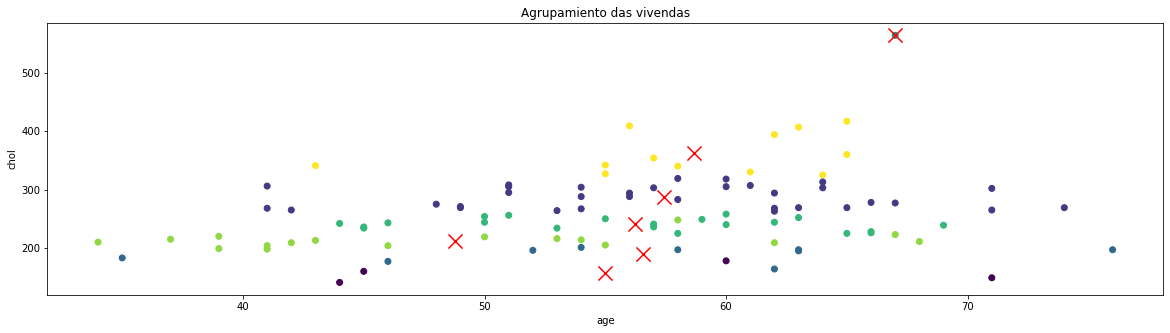

In [13]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, :2]

ax1.scatter(mujeres_estudio['age'], mujeres_estudio['chol'], c=clusters_mellor)  
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1], s=200, marker='x', color='red')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("age")  # Nombramos os eixos
ax1.set_ylabel("chol")

plt.show()  # Mostramos a figura por pantalla

Como se puede observar, los centroides están más próximos, a excepción del superior, qeu difiere más del resto. Aün así, se observa como la variable colesterol sigue siendo más determinante a la hora de clasificar a los pacientes, como ocurrirá también en el resto de evaluaciones con el tipo de dolor de pecho y la presión sanguínea. 

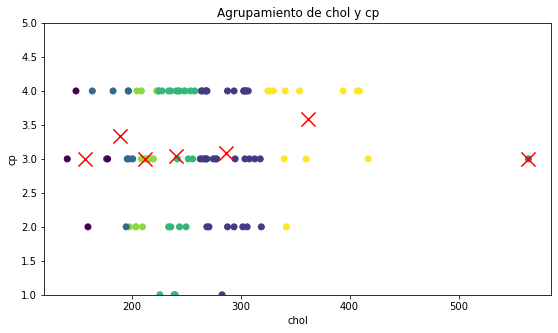

In [14]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, [1, 3]]
ax1.scatter(mujeres_estudio['chol'], mujeres_estudio['cp'], c=clusters_mellor) 
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='red')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("cp")

ax1.set_ylim(1, 5)



plt.show()  # Mostramos a figura por pantalla

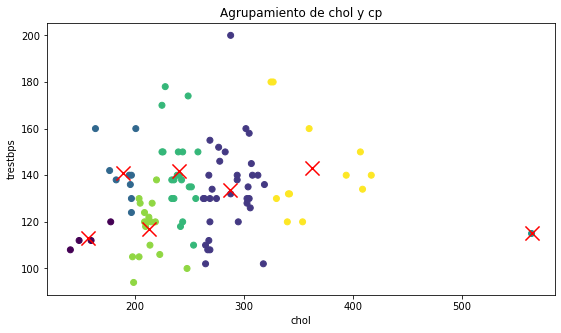

In [15]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, [1, 2]]
ax1.scatter(mujeres_estudio['chol'], mujeres_estudio['trestbps'], c=clusters_mellor)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='red')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("trestbps")



plt.show()  # Mostramos a figura por pantalla

Por lo que se puede concluír que el colesterol es una variable con mucho peso a la hora de clasificar a los pacientes que son mujeres, y por lo tanto es una característica muy a tener en cuenta en el análisis médico. Por último, vemos como hay siguen una pequeña distribución normal en cuanto a esta característica, centrada en torno a 250, lo que indica que la mayoría de los pacientes perteneceran a los clusters centrales. 


De forma similar, se va a realizar el análisis para los hombres. Se aportará una conclusión final tras mostrar todas las tablas y datos. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 0 to 302
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       206 non-null    int64
 1   chol      206 non-null    int64
 2   trestbps  206 non-null    int64
 3   cp        206 non-null    int64
dtypes: int64(4)
memory usage: 8.0 KB


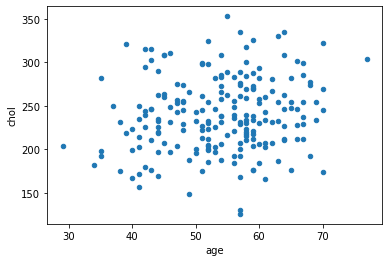

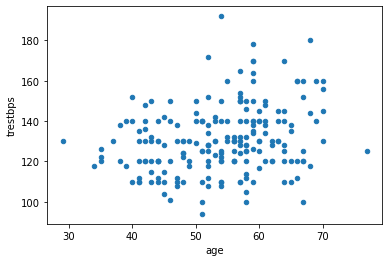

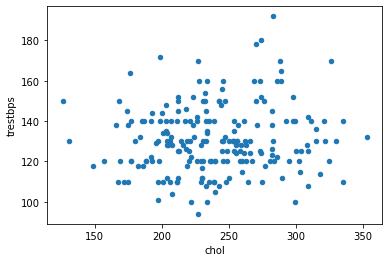

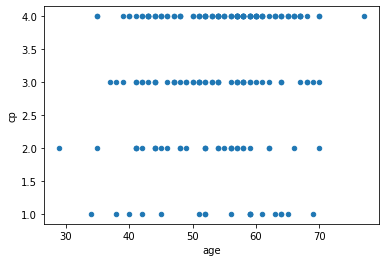

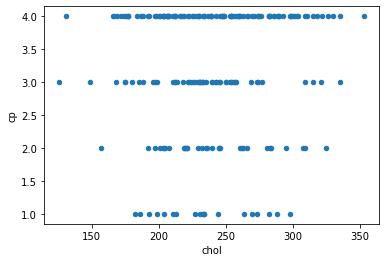

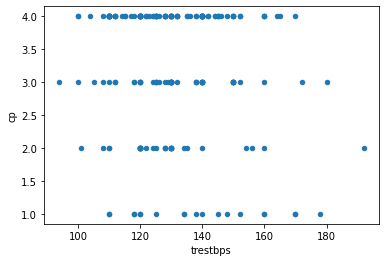

In [27]:
#Se muestran gráficas agrupando las variables de 2 en 2 para obtener un pequeño análisis inicial. 

hombres_estudio = hombres[['age','chol','trestbps', 'cp']]
hombres_estudio.info()

hombres_estudio.plot(kind='scatter', x='age', y='chol')
hombres_estudio.plot(kind='scatter', x='age', y='trestbps')
hombres_estudio.plot(kind='scatter', x='chol', y='trestbps')
hombres_estudio.plot(kind='scatter', x='age', y='cp')
hombres_estudio.plot(kind='scatter', x='chol', y='cp')
hombres_estudio.plot(kind='scatter', x='trestbps', y='cp')

hombres_mat = hombres_estudio.values
#Recordar que las columnas son Edad, Colesterol, Presión Sanguínea y Tipo de dolor de pecho (en ese orden)


In [28]:


from sklearn.cluster import KMeans


# Definimos o número de iteracións
n_iter = 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = hombres_mat[np.random.choice(hombres_mat.shape[0], size=4, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento2 = model.fit(hombres_estudio)
np.random.seed(SEED_VALUE)
agrupamento2 = model.fit(hombres_estudio)


# Centroides obtidos coa función KMeans
agrupamento2.cluster_centers_


array([[ 55.05      , 302.975     , 133.875     ,   3.325     ],
       [ 53.95652174, 223.10144928, 127.1884058 ,   3.04347826],
       [ 55.34545455, 257.47272727, 133.94545455,   3.2       ],
       [ 50.5       , 182.95238095, 130.23809524,   3.16666667]])

In [30]:
# Obtener las asignaciones de clúster para cada muestra
clusters_asignados = agrupamento2.labels_

# Custo final coa función KMeans
agrupamento2.inertia_ / len(hombres_estudio)

543.4672022873003

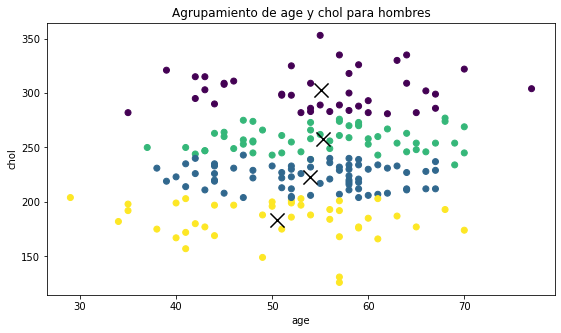

In [31]:

fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento2.cluster_centers_[:, :2]
ax1.scatter(hombres_estudio['age'], hombres_estudio['chol'], c=agrupamento2.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de age y chol para hombres")  # Poñemos un título
ax1.set_xlabel("age")  # Nombramos os eixos
ax1.set_ylabel("chol")


plt.show()  # Mostramos a figura por pantalla

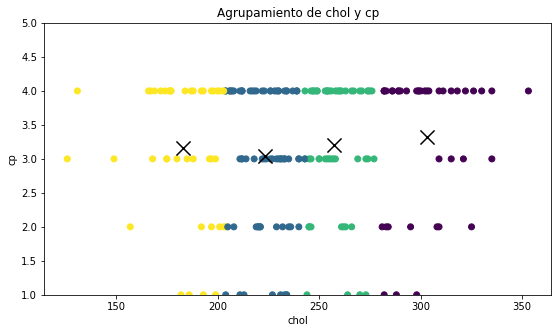

In [32]:

fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento2.cluster_centers_[:, [1, 3]]
ax1.scatter(hombres_estudio['chol'], hombres_estudio['cp'], c=agrupamento2.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("cp")

ax1.set_ylim(1, 5)



plt.show()  # Mostramos a figura por pantalla

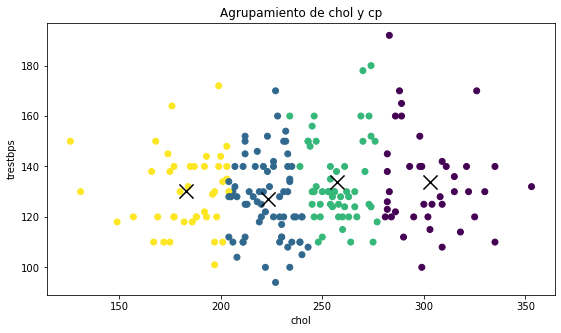

In [33]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = agrupamento2.cluster_centers_[:, [1, 2]]
ax1.scatter(hombres_estudio['chol'], hombres_estudio['trestbps'], c=agrupamento2.labels_)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='black')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("trestbps")




plt.show()  # Mostramos a figura por pantalla

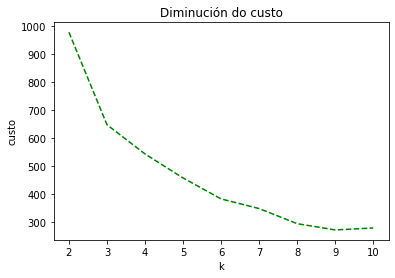

In [34]:

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    centr_iniciais = hombres_mat[np.random.choice(hombres_mat.shape[0], size=k, replace=False)]

    model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)
    
    # Axustamos o modelo aos datos
    np.random.seed(SEED_VALUE)
    agrupamento2 = model.fit(hombres_estudio)
    custo_final = agrupamento2.inertia_ / len(hombres_estudio)

    custos_finais.append(custo_final)
    centroides_finais.append(agrupamento2.cluster_centers_)
    clusters_finais.append( agrupamento2.labels_ )
    
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

In [35]:
k_mellor = 6
# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor = clusters_finais[k_mellor-2]
custos_mellor = custos_finais[k_mellor-2]
print(centroides_mellor)
print(clusters_mellor)
print(custos_mellor)


[[ 54.42307692 312.46153846 128.15384615   3.53846154]
 [ 53.41666667 260.47916667 126.29166667   3.33333333]
 [ 60.76470588 276.11764706 160.47058824   2.64705882]
 [ 54.7        217.86       140.52         2.94      ]
 [ 52.08823529 225.38235294 113.17647059   3.14705882]
 [ 50.70967742 176.80645161 128.12903226   3.25806452]]
[3 2 4 1 4 1 3 5 1 1 3 5 4 3 1 4 1 3 3 1 5 4 0 3 4 3 5 2 0 3 3 3 4 5 3 5 5
 0 3 1 1 3 5 1 3 3 5 2 5 3 0 3 1 1 1 5 1 1 2 4 0 2 0 3 1 0 3 1 4 3 4 1 5 5
 0 5 4 1 4 1 5 3 3 0 1 1 4 3 2 4 4 1 4 3 1 5 1 5 1 3 2 3 0 4 4 2 1 0 2 2 1
 0 0 0 0 1 4 0 1 3 3 1 2 3 3 2 4 5 0 1 1 1 2 4 2 2 1 5 0 1 0 3 2 5 4 0 1 3
 1 4 3 4 5 1 1 4 4 4 5 1 1 1 0 4 3 4 4 1 3 3 4 3 1 0 2 1 4 5 0 3 3 3 5 3 3
 0 3 3 3 0 1 5 3 0 4 3 4 3 5 5 5 5 1 3 5 5]
383.23427154765403


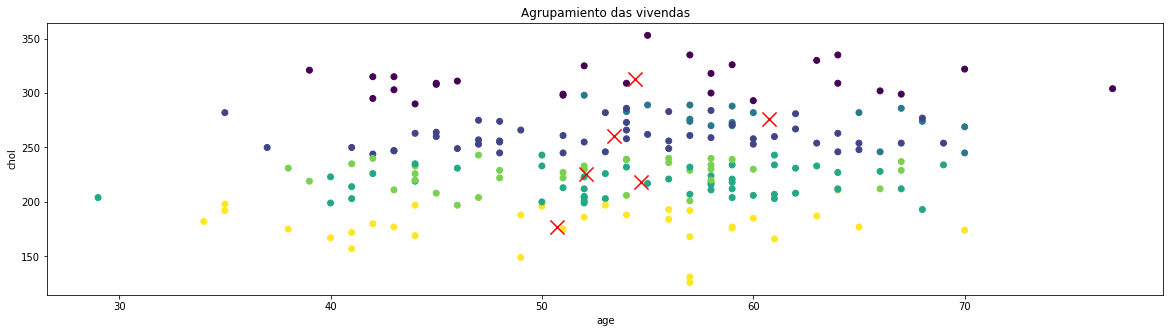

In [36]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, :2]

ax1.scatter(hombres_estudio['age'], hombres_estudio['chol'], c=clusters_mellor)  
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1], s=200, marker='x', color='red')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("age")  # Nombramos os eixos
ax1.set_ylabel("chol")

plt.show()  # Mostramos a figura por pantalla

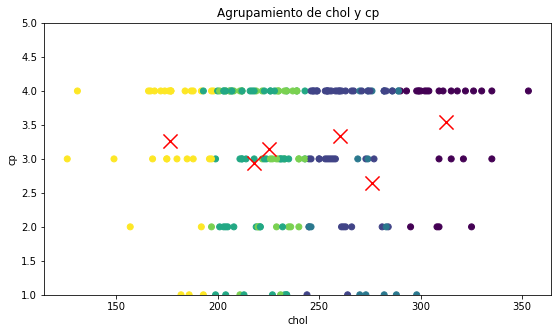

In [37]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, [1, 3]]
ax1.scatter(hombres_estudio['chol'], hombres_estudio['cp'], c=clusters_mellor) 
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='red')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("cp")

ax1.set_ylim(1, 5)



plt.show()  # Mostramos a figura por pantalla

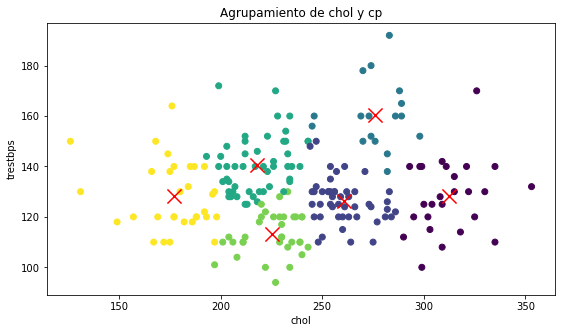

In [39]:
fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

# Engadimos os scatterplots
centros_a_graficar = centroides_mellor[:, [1, 2]]
ax1.scatter(hombres_estudio['chol'], hombres_estudio['trestbps'], c=clusters_mellor)  #Vivendas
ax1.scatter(centros_a_graficar[:, 0], centros_a_graficar[:, 1],
            s=200, marker='x', color='red')  # Centroides
ax1.set_title("Agrupamiento de chol y cp")  # Poñemos un título
ax1.set_xlabel("chol")  # Nombramos os eixos
ax1.set_ylabel("trestbps")



plt.show()  # Mostramos a figura por pantalla

En el caso de los hommbres, vemos como el número óptimo de centroides es de 6, creando así 6 clusters distintos para clasificarlos, por lo que hay una diferencia respecto a las mujeres. 
Por otro lado, los hombres siguen teniendo la variable colesterol como la que más peso tiene a la hora de agrupar, siendo por la tanto de nuevo la variable de más relevancia a analizar en los análisis médicos. 
La dispersión de los datos es similar a las de las mujeres, pero cabe destacar que hay el doble de datos (recordar que se ha supuesto que el 0 es mujer y el 1 es hombre), lo que hace pensar que hay más enfermedades cardíacas en los hombres. 

**************************************************************